# MRI reconstruction from multicoil data

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os
import sigpy.mri as mr

import sigpy as sp
import sigpy.mri as mr
from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL
import h5py
from skimage.metrics import structural_similarity as ssim

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable

# from facebook MRI
#import transforms
from data import transforms as transform

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '2'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


# Loading and plotting fastMRI data

In [2]:
### Get image from the validation set
filename = './fastMRIdata/file1000190.h5' # default 2

f = h5py.File(filename, 'r') # contains a kspace measurement f['kspace'] and rss reconstruction f['reconstruction_rss']
print("Kspace shape (number slices, number coils, x, y): ", f['kspace'].shape)
print("reconstruction_rss shape", f['reconstruction_rss'].shape)

# which slice to consider
slicenu = 16

slice_ksp = f['kspace'][slicenu]
#width = slice_ksp.shape[2]
#print("slice_ksp.shape", slice_ksp.shape)
#offset = max(0, int((width-352)/2))
#slice_ksp = slice_ksp[:,:,offset:offset+352] # to make sure that the width is divisible by 2^4 or 2^5

print("ksp shape (number slices, x, y):",slice_ksp.shape)

slice_ksp2 = transform.to_tensor(slice_ksp)      # Convert from numpy array to pytorch tensor
slice_image = transform.ifft2(slice_ksp2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = transform.complex_abs(slice_image)   # Compute absolute value to get a real image

scale_factor = 1./( np.max( slice_image_abs.cpu().numpy() ) / 12.0 ) # 5 works well
slice_ksp = slice_ksp*scale_factor # scale for deep decoder

Kspace shape (number slices, number coils, x, y):  (36, 15, 640, 368)
reconstruction_rss shape (36, 320, 320)
ksp shape (number slices, x, y): (15, 640, 368)


## Measurement and forward model

In [3]:
# kspace is (numslices, x, y) dimensional and complex-valued
# need (1,numslices,x,y) as output of decoder
# forward model
#    input: (1,numslices,x,y), complex-valued
#    output: (1,numslices,x,y,2), real-valued, where the 2 at the end corresponds to real and complex parts

# generate measurement
def ksp2measurement(ksp):
    return np_to_var( np.transpose( np.array([np.real(ksp),np.imag(ksp)]) , (1, 2, 3,0)) )

measurement = ksp2measurement(slice_ksp).type(dtype)

print(measurement.shape,torch.min(measurement))

torch.Size([1, 15, 640, 368, 2]) tensor(-235.5499, device='cuda:0')


## Least-squares estimate from full kspace measurement

The least-squares estimate is obtained from the full kspace measurement by first computing the least estimate for each coil slice and then computing an estimate of the final image via the root sum of squares algorithm:
$$
x_{result} = \sqrt{\sum_{i=1}^n x_i }.
$$
Here, $x_i$ is the $i$-th entry of the image.

In [4]:
# reconstruct from full kspace measurement with build-in function
slice_image_rss = transform.root_sum_of_squares(slice_image_abs, dim=0)

In [5]:
# reconstruct from full kspace measurement by hand
def lsreconstruction(measurement,mode='both'):
    # measurement has dimension (1, num_slices, x, y, 2)
    fimg = transform.ifft2(measurement)
    normimag = torch.norm(fimg[:,:,:,:,0])
    normreal = torch.norm(fimg[:,:,:,:,1])
    print("real/img parts: ",normimag, normreal)
    if mode == 'both':
        return torch.sqrt(fimg[:,:,:,:,0]**2 + fimg[:,:,:,:,1]**2)
    elif mode == 'real':
        return torch.tensor(fimg[:,:,:,:,0]) #torch.sqrt(fimg[:,:,:,:,0]**2)
    elif mode == 'imag':
        return torch.sqrt(fimg[:,:,:,:,1]**2)
    #return torch.abs( fimg[:,:,:,:,0] )

real/img parts:  tensor(1426.7501, device='cuda:0') tensor(1276.2098, device='cuda:0')


(-0.5, 319.5, 319.5, -0.5)

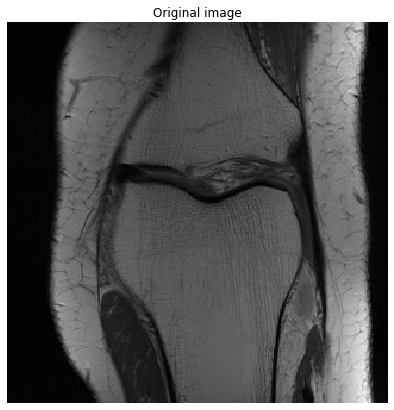

In [6]:
def root_sum_of_squares(lsimg):
    out = np.zeros(lsimg[0].shape)
    for img in lsimg:
        out += img**2
    return np.sqrt(out)

def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

lsimg = lsreconstruction(measurement)
lsrec = crop_center( root_sum_of_squares(var_to_np(lsimg)) , 320,320)

fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
ax1 = fig.add_subplot(121)
ax1.imshow(lsrec,cmap='gray')
ax1.set_title('Original image')
ax1.axis('off')

# Undersample and reconstruct

In [7]:
from common.subsample import MaskFunc
mask_func = MaskFunc(center_fractions=[0.07], accelerations=[4])  # Create the mask function object

In [8]:
masked_kspace, mask = transform.apply_mask(slice_ksp2*scale_factor, mask_func)   # Apply the mask to k-space

In [9]:
np.linalg.norm( masked_kspace[5,:,:,0].cpu().numpy() ), np.linalg.norm( masked_kspace[5,:,:,1].cpu().numpy() )

(500.9254, 416.30334)

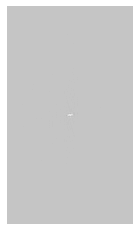

In [10]:
plt.imshow(  masked_kspace[5,:,:,0]  ,cmap='gray')
plt.axis('off')
plt.show()

In [11]:
unders_measurement = np_to_var( masked_kspace.data.cpu().numpy() ).type(dtype)

torch.Size([1, 1, 368, 1])
undersampling by: 0.2391304347826087
mask2d shape: (640, 368)


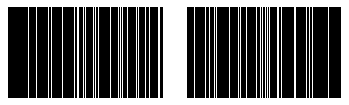

In [12]:
print(mask.shape)

#mask1d = var_to_np(mask)[0,offset:offset+352,0]
mask1d = var_to_np(mask)[0,:,0]
print("undersampling by:", sum(mask1d)/len(mask1d))
mask2d = np.array([mask1d]*640)
print("mask2d shape:", mask2d.shape )
plt.imshow(mask2d[:100,:],cmap='gray')
plt.axis('off')
plt.show()

## Least squares reconstruction

In [13]:
sampled_image = transform.ifft2(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = transform.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = transform.root_sum_of_squares(sampled_image_abs, dim=0)

(-0.5, 367.5, 639.5, -0.5)

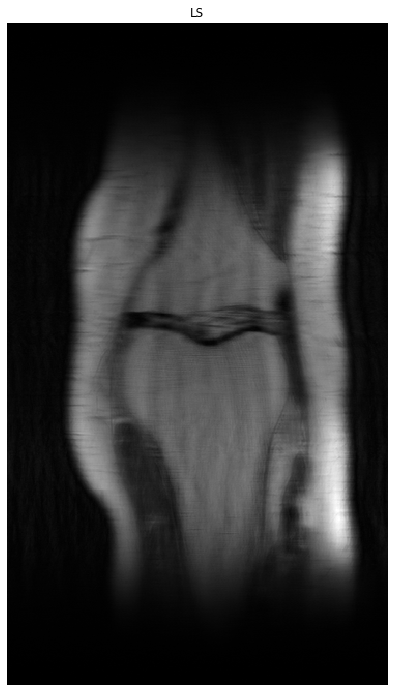

In [14]:
fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
ax1 = fig.add_subplot(121)
ax1.imshow(sampled_image_rss,cmap='gray')
ax1.set_title('LS')
ax1.axis('off')

# Reconstruction with deep decoder from full measurement

In [15]:
# the forward model - treats real and complex part of each slice as a separate channel
def forwardm(img,mask=mask2d):
    # img has dimension (2*num_slices, x,y)
    # output has dimension (1, num_slices, x, y, 2)
    mask = np_to_var(mask)[0].type(dtype)
    s = img.shape
    ns = int(s[1]/2) # number slices
    fimg = Variable( torch.zeros( (s[0],ns,s[2],s[3],2 ) ) ).type(dtype)
    for i in range(ns):
        fimg[0,i,:,:,0] = img[0,2*i,:,:]
        fimg[0,i,:,:,1] = img[0,2*i+1,:,:]
    #fimg[:,:,:,:,0] = img # real part of the image
    #Fimg = transform.fft2(fimg)
    Fimg = transform.fft2(fimg) # dim: (1,num_slices,x,y,2)
    for i in range(ns):
        Fimg[0,i,:,:,0] *= mask
        Fimg[0,i,:,:,1] *= mask
    return Fimg

## Deep decoder 

### Deep decoder setup

In [16]:
output_depth = measurement.shape[1]*2
sh = slice_ksp.shape
dummy = torch.zeros( ( 1,sh[0]*2,sh[1],sh[2] ) )
out_size = dummy.shape[2:]

print("number slices",output_depth)

#num_channels = [256]*6 #
num_channels = [384]*6 #
in_size = ( int(out_size[0]/25) , int(out_size[1]/25) )

print("in_size", in_size)

net = deepdecoder( in_size,
                    out_size,
                output_depth,
                  num_channels=num_channels,
                need_sigmoid=False,
                #need_tanh=True,
               ).type(dtype)

print(net)

number slices 30
in_size (25, 14)
[(43, 25), (74, 42), (127, 72), (218, 124), (373, 214), torch.Size([640, 368])]
Sequential(
  (1): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (2): Upsample(size=(43, 25), mode=bilinear)
  (3): ReLU()
  (4): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (6): Upsample(size=(74, 42), mode=bilinear)
  (7): ReLU()
  (8): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (10): Upsample(size=(127, 72), mode=bilinear)
  (11): ReLU()
  (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): Sequential(
 

In [17]:
def channels2imgs(out):
    sh = out.shape
    chs = int(sh[0]/2)
    imgs = np.zeros( (chs,sh[1],sh[2]) )
    for i in range(chs):
        imgs[i] = np.sqrt( out[2*i]**2 + out[2*i+1]**2 )
    return imgs

### Check if scale is right

In [18]:
# get net input
totalupsample = 2**len(num_channels)
shape = [1,num_channels[0], int(dummy.data.shape[2]/totalupsample), int(dummy.data.shape[3]/totalupsample)]
print("input shape: ", shape)
ni = Variable(torch.zeros(shape)).type(dtype)
ni.data.uniform_()
ni.data *= 1./10

# generate random image
net(ni)
out_chs = net( ni.type(dtype) ).data.cpu().numpy()[0]
out_imgs = channels2imgs(out_chs)

rec = root_sum_of_squares(out_imgs)

# least squares reconstruciton
orig = root_sum_of_squares(var_to_np(lsreconstruction(unders_measurement))) 

print("those norms should be similar for scale to be right:", np.linalg.norm(orig), np.linalg.norm(rec))

input shape:  [1, 384, 10, 5]
real/img parts:  tensor(1405.3978, device='cuda:0') tensor(1258.4099, device='cuda:0')
those norms should be similar for scale to be right: 1886.4618701926372 1524.4964638229653


### Fit deep decoder

In [19]:
sampled_image.shape, dummy.shape

out = []
for img in sampled_image:
    out += [ img[:,:,0].numpy() , img[:,:,1].numpy() ]
lsest = torch.tensor(np.array([out]))

In [20]:
mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=0.0,
                        num_iter=10000,
                        img_noisy_var=unders_measurement,
                        LR = 0.01, # 0.0025
                        net=net,
                        apply_f = forwardm,
                        img_clean_var=Variable(lsest).type(dtype),
                        upsample_mode='free',
                        in_size = in_size,
                        find_best=True, # default is False
                        )

input shape:  [1, 384, 25, 14]
optimize with adam 0.01


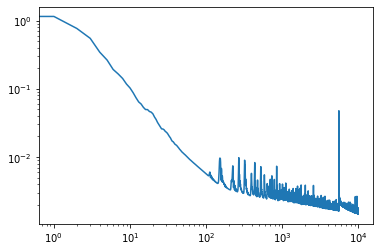

In [21]:
#plt.semilogx(mse_n)
plt.loglog(mse_n)

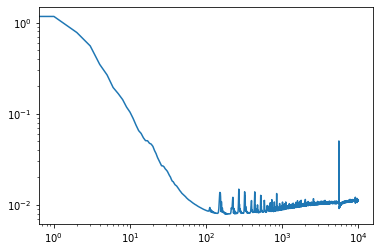

In [22]:
#plt.semilogx(mse_n)
plt.loglog(mse_t)

In [23]:
out_chs = net( ni.type(dtype) ).data.cpu().numpy()[0]
out_imgs = channels2imgs(out_chs)

print(out_chs.shape,out_imgs.shape)

(30, 640, 368) (15, 640, 368)


rec: 4.406230926513672 2.881086584238801e-05
orig: 4.390025 7.241257e-05
rec: 3.521644115447998 2.268174102937337e-05
orig: 3.7799618 0.00023863862
rec: 4.377137184143066 3.1118055630940944e-05
orig: 4.276587 0.00020187793
rec: 0.9847229719161987 1.1905482097063214e-05
orig: 1.211269 0.00016133166
rec: 3.9394278526306152 3.120233668596484e-05
orig: 4.2864647 0.00015639148
rec: 6.80875301361084 1.6289321138174273e-05
orig: 6.9567585 0.00021654835
rec: 7.1256842613220215 1.0317624401068315e-05
orig: 7.266386 0.00019405628
rec: 7.116391658782959 1.6519925338798203e-05
orig: 7.9281874 7.073204e-05
rec: 1.4139641523361206 1.1178795830346644e-05
orig: 1.7270542 0.00025744623
rec: 1.8991092443466187 2.329826202185359e-05
orig: 2.1016512 0.00020539325
rec: 10.779797554016113 1.8066457414533943e-05
orig: 12.000001 0.0003386473
rec: 9.490042686462402 3.204992026439868e-05
orig: 10.41271 0.00017986899
rec: 9.396520614624023 6.724595004925504e-05
orig: 10.760595 0.00010919426
rec: 10.8612327575683

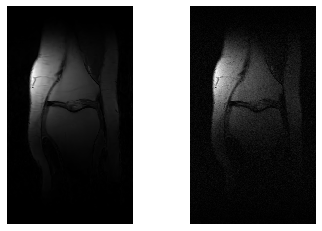

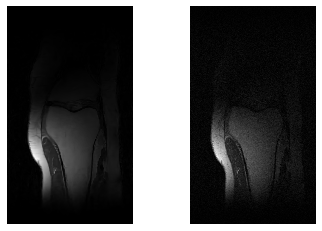

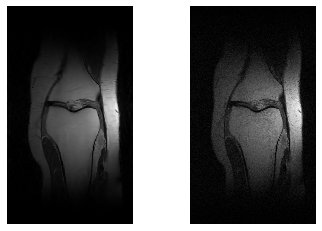

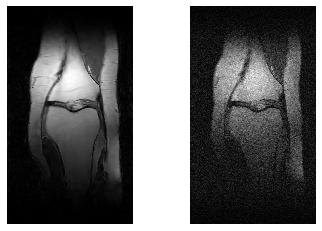

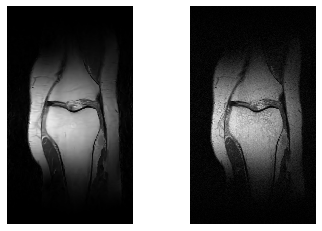

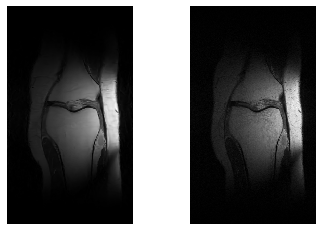

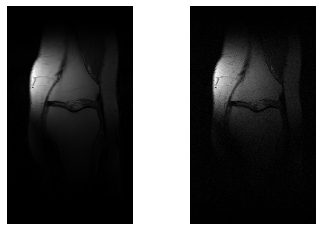

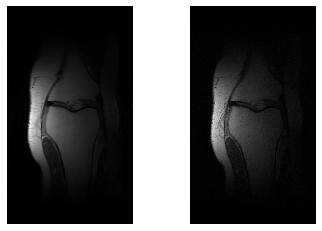

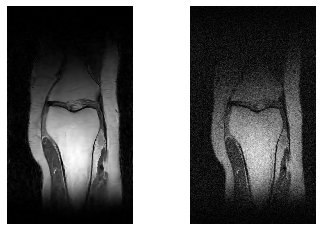

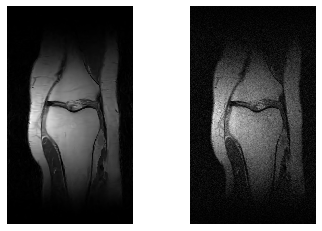

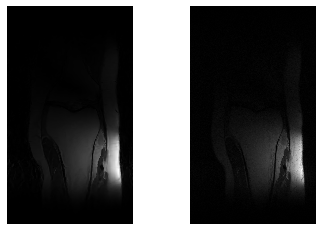

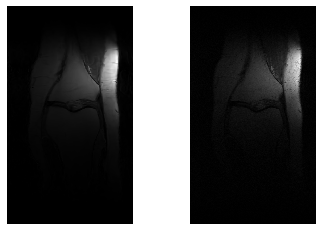

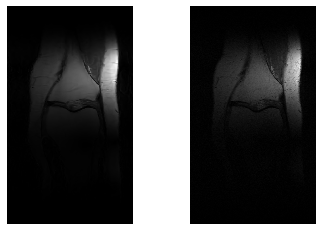

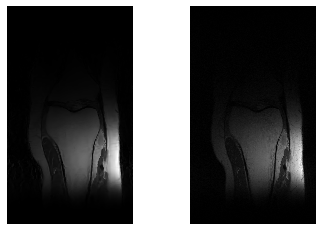

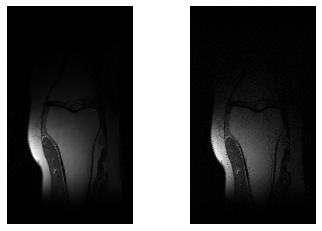

In [24]:
for img,imgorig in zip([img for img in out_imgs],[img for img in var_to_np(lsimg)]):
    print("rec:", np.max(img), np.min(img))
    print("orig:", np.max(imgorig), np.min(imgorig))
    fig = plt.figure() 
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(img,cmap='gray')
    ax1.axis('off')
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(imgorig,cmap='gray')
    ax2.axis('off')
    fig.show()

In [25]:
# least squares reconstruciton
lsimg = lsreconstruction(measurement)
orig = crop_center( root_sum_of_squares(var_to_np(lsimg)) , 320,320)

# deep decoder reconstruction
rec = crop_center(root_sum_of_squares(out_imgs),320,320)

# normalize
#rec_n = rec / np.linalg.norm(rec)
#orig_n = orig / np.linalg.norm(orig)
rec_n = rec
orig_n = orig

print(np.linalg.norm(rec_n-orig_n) / np.linalg.norm(orig_n) )

ssim_const = ssim(orig_n, rec_n,data_range=orig_n.max() - orig_n.min())
print(ssim_const)
print(psnr(orig_n,rec_n,np.max(orig_n)))

real/img parts:  tensor(1426.7501, device='cuda:0') tensor(1276.2098, device='cuda:0')
0.0666646451877105
0.8050259461219524
33.09538229564412


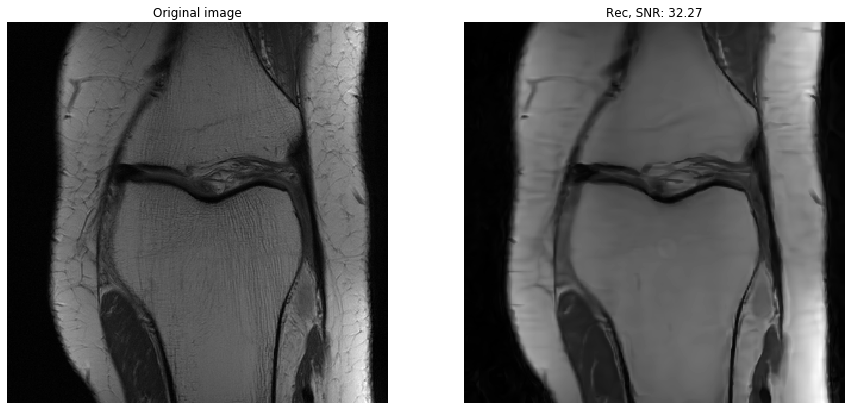

In [26]:
fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
    
ax1 = fig.add_subplot(121)
ax1.imshow(orig_n,cmap='gray')
ax1.set_title('Original image')
ax1.axis('off')

ax2 = fig.add_subplot(122)
ax2.imshow(rec_n,cmap='gray')
ax2.set_title( "Rec, SNR: %.2f" % psnr(orig,rec,np.max(rec)) ) 
ax2.axis('off')    
    
plt.show()

In [27]:
def savemtx_for_logplot(A,filename = "exp.dat"):
    ind = sorted(list(set([int(i) for i in np.geomspace(1, len(A[0])-1 ,num=1000)])))
    A = [ [a[i] for i in ind]  for a in A]
    X = np.array([ind] + A)
    np.savetxt(filename, X.T, delimiter=' ')

R = np.vstack( (np.array([k for k in range(len(mse_n))]),mse_n,mse_t) ).T

savemtx_for_logplot( R.T, "CS_convergence_MRI.dat")